In [ ]:
!pip install -q torchinfo

# Import Library


In [ ]:
import numpy as np
import os
import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from PIL import Image
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import albumentations as alb
from albumentations.pytorch import ToTensorV2
import cv2
import torch
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
import time
from torch.utils.data import TensorDataset, DataLoader

# Import the Dataset

The image dataset is sourced from the OASIS website, which provides a collection of Alzheimer’s
and other brain-related MRI images:

- **Original Source:** OASIS Brains Website (Open Access Series of Imaging Studies (OA-
SIS), 2019)

- **Cleaned and Organized Dataset:** Kaggle: Alzheimer’s MRI Images Dataset (Marcus
et al., 2007)

For convenience, the Kaggle dataset will be used in this project as it is pre-organized into folders
based on labels.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1


# Data Cleaning and Processing

## Data Overview


Check the number of dataset for each category to get the information
about the distribution and if either it’s balanced or not.

In [ ]:
os.listdir(path)

['AugmentedAlzheimerDataset', 'OriginalDataset']

In [ ]:
folder_path = os.path.join(path, 'AugmentedAlzheimerDataset')  # path is from the previous cell
print("Listing files from:", folder_path)
class_names = os.listdir(folder_path)
print(class_names)

Listing files from: /root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1/AugmentedAlzheimerDataset
['ModerateDemented', 'MildDemented', 'NonDemented', 'VeryMildDemented']


In [ ]:
# Check the imbalance number of dataset for each category
data = []
total_count = 0

for folder in os.listdir(folder_path):
    count = len(os.listdir(os.path.join(folder_path, folder)))
    total_count += count
    data.append({"Folder": folder, "Count": count})

for item in data:
    item["Percentage"] = np.round((item["Count"] / total_count) * 100, 2)

df = pd.DataFrame(data)
df = df.sort_values(by="Count", ascending=False).reset_index(drop=True)
print(df)

             Folder  Count  Percentage
0       NonDemented   9600       28.25
1      MildDemented   8960       26.37
2  VeryMildDemented   8960       26.37
3  ModerateDemented   6464       19.02


From the Figure, it seems the data is imbalanced since the gap between each category
especially Moderate Dementia and Non Demented is very big.
To solve that case, we actually have two options:

- Reduce the number of dataset to be 488 for each category (since the smallest category
is Moderate Dementia and only has 488 dataset)

- Increase the number of datasets by using data augmentation.
We successfully used the first options. However, we also try the second options and see if
it improves the performance.

## Data Management

After importing, we need to manage the dataset and get the dataset
file location into the array. In this case, it would help us to train the model by using this
array to access each file in the folder.

- Creates a 2D list (array) with 4 empty lists (4 because we have 4 categories) which
will store file paths.

- Loops through all folders inside a given folder path. Walks through each folder
(including subfolders) to find all files.

- Stores the full path of each file in one of the 4 lists inside the array.

- Increases count to move to the next list (but incorrectly, so it may cause an error).

In [ ]:
# Get the filename path into the array

rows = 4
array = [[] for _ in range(rows)]
count = 0


for folder in os.listdir(folder_path):
  for dirname, _, filenames in os.walk(os.path.join(folder_path, folder)):
    for filename in filenames:
        array[count].append(os.path.join(dirname, filename))
    count += 1

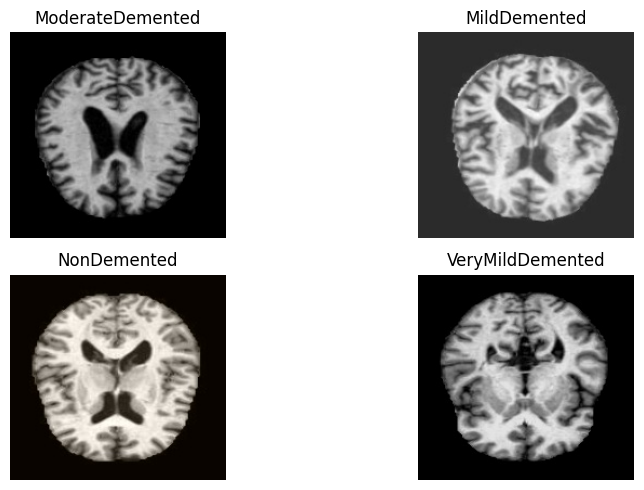

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Number of categories (assuming 4)
num_categories = len(class_names)

# Set up the figure for a 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(10, 5))  # 2 rows, 2 columns

# Flatten the 2D axes array to loop through it easily
axes = axes.flatten()

# Loop through each category and display one sample image
for i in range(num_categories):
    if len(array[i]) > 0:  # Ensure there's an image in the category
        img_path = array[i][0]  # Pick the first image in the category
        img = Image.open(img_path)  # Open image using PIL

        # Display the image
        axes[i].imshow(img)
        axes[i].axis("off")  # Hide axis for better visualization
        axes[i].set_title(class_names[i])  # Set category name as title

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


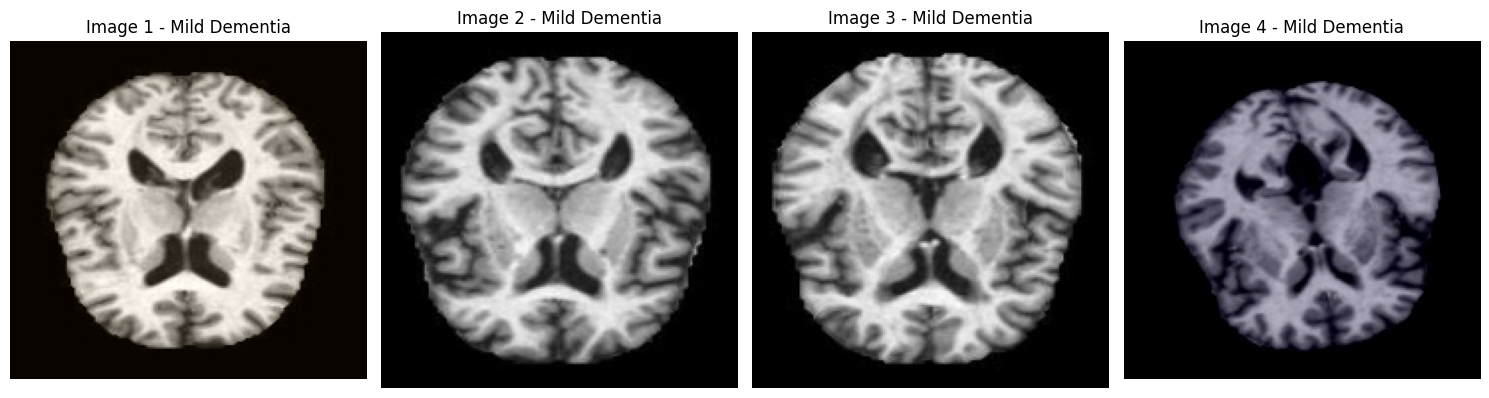

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Set up the figure for a 2x2 layout (4 images)
fig, axes = plt.subplots(1, 4, figsize=(15, 8))
axes = axes.flatten()

# Loop through the first 4 images in category 2 (index 1)
for i in range(4):
    if i < len(array[1]):  # Make sure the image exists
        img_path = array[2][i]
        img = Image.open(img_path)

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f'Image {i + 1} - Mild Dementia')

# Adjust layout
plt.tight_layout()
plt.show()


### Algumentation Implementation

Due to the issue of imbalance, data augmentation would be crucial
to help the model get the knowledge of each category equally. Minority category such as
Moderate Dementia need to be augmented by using some method, such as:

**(a) Random cropping**

- Crops a random 250x250 region from the original image.

- Helps in augmenting images by providing different perspectives and removing
unnecessary parts.

**(b) Horizontal Flipping**

- Flips the image horizontally with a 50% probability (p=0.5).

- Helps the model learn invariance to left-right orientation.

**(c) Random Brightness contrast**

- Randomly adjusts the brightness and contrast of the image with a 20% probability
(p=0.2).

- Helps the model generalize to different lighting conditions.

**(d) Image rotation**

- Rotates the image randomly within a ±20-degree range with a 50% probability
(p=0.5).

- Helps the model learn rotation-invariant features.

**(e) Normalization**

- Normalizes pixel values using the mean and standard deviation from the ImageNet
dataset.

- Ensures consistency in input data and improves model training.
Using this method, we want to increase the number of dataset for Moderate Dementia to
be 1000 (which is 2 times higher than our first method and could be increased to be 5000
if we want as well). Then, we would see if there is an improvement in the performance.

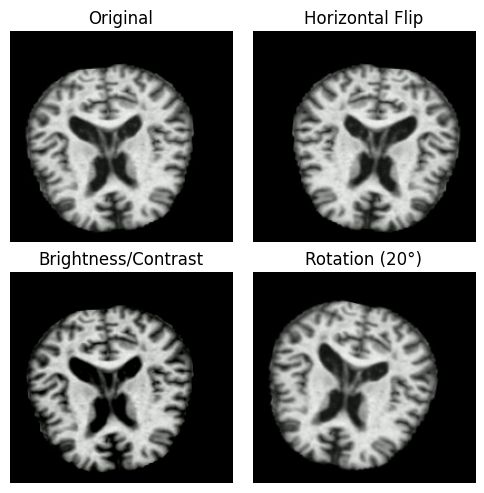

In [ ]:
import albumentations as alb
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load an example image (replace with an actual image path)
image_path = array[0][1]
original_img = cv2.imread(image_path)  # Read image
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Get image dimensions
img_height, img_width = original_img.shape[:2]

# Set crop size dynamically (ensure it doesn't exceed image dimensions)
crop_height = min(250, img_height)
crop_width = min(250, img_width)

# Function to apply a single transformation for visualization
def apply_single_transform(transform_func, img):
    augmented = transform_func(image=img)["image"]
    return augmented

# Define transformations with adjusted crop size
transforms = {
    "Original": None,  # No transformation
    "Horizontal Flip": alb.Compose([alb.HorizontalFlip(p=1.0)]),  # Always apply
    "Brightness/Contrast": alb.Compose([alb.RandomBrightnessContrast(p=1.0)]),
    "Rotation (20°)": alb.Compose([alb.Rotate(limit=20, p=1.0)])
}

# Apply transformations and store results
results = {"Original": original_img}
for name, transform_func in transforms.items():
    if transform_func:  # Skip "Original" since it has no transformation
        results[name] = apply_single_transform(transform_func, original_img)

# Plot before and after for each transformation in a 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(5, 5))

for ax, (title, img) in zip(axes.flatten(), results.items()):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()


## Handle the imbalance dataset

In [ ]:
# Limit the number of dataset
dataset_per_cat = 6000

for index in range(0,4):
  array[index] = array[index][0:dataset_per_cat]

## OneHotEncoding

The dataset is divided into four categories: Non-Demented, Mild De-
mentia, Moderate Dementia, and Very Mild Dementia. These string labels will be converted
into integer labels using one-hot encoding for compatibility with the deep learning model.

• **Categories:** {Non-Demented, Mild Dementia, Moderate Dementia, Very Mild De-
mentia}

• **Integer Encoding:** {0, 1, 2, 3}

In [ ]:
encoder = OneHotEncoder()
encoder.fit([[0],[1],[2],[3]])

OneHotEncoder()

## Resize the Image

Each image in the dataset will be resized to (128, 128, 3) dimensions to ensure uniformity. This step is essential as the deep learning model requires input
images to have consistent dimensions.

In [ ]:
# Resize the image

data = []
result = []

for index in range(0,4):
  for path in array[index]:
      img = Image.open(path)
      img = img.resize((128,128))
      img = np.array(img)
      if(img.shape == (128,128,3)):
          data.append(np.array(img))
          result.append(encoder.transform([[index]]).toarray())

In [ ]:
data = np.array(data)
data.shape

(24000, 128, 128, 3)

In [ ]:
result = np.array(result)
result = result.reshape((dataset_per_cat * 4,4))
result.shape

(24000, 4)

The dataset will be split into training and testing sets using the
train test split function from the sklearn.model selection module, with
15% of the data allocated to the test set.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(data,result,test_size=0.15,shuffle=True,random_state=50)
np.unique(y_train)

array([0., 1.])

In [ ]:
print(f"Number of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")


Number of training samples: 20400
Number of testing samples: 3600


# Baseline Model

The baseline model chosen for comparison is a **Random Forest classifier** due to its simplicity, inter-
pretability, and widespread use as a reference in classification tasks. It provides a minimum perfor-
mance benchmark, allowing us to assess whether more complex models, such as neural networks,
are necessary. In this case, we use Random Forest because it offers a balance between accuracy and
efficiency while being less prone to overfitting compared to more complex models.

Accuracy: 0.7425
Recall: 0.7425
Precision: 0.7395


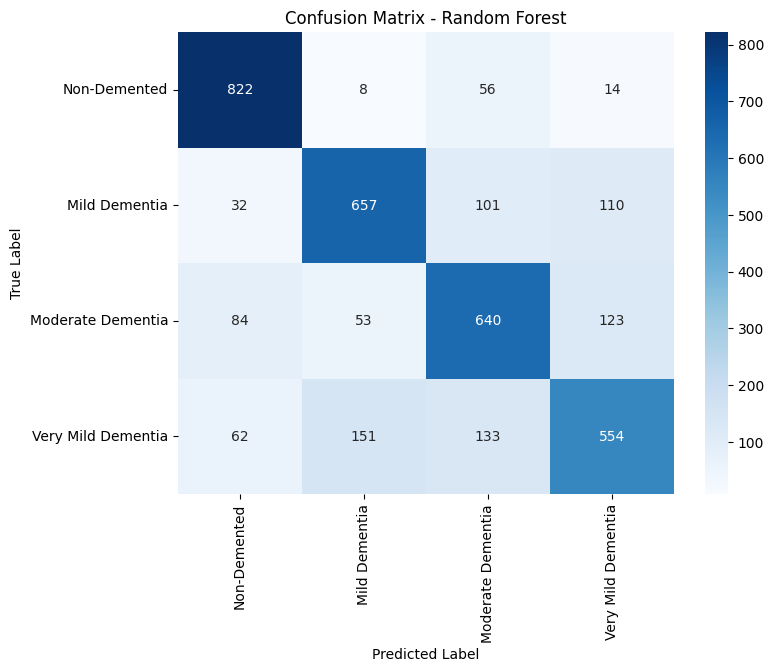

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score

# Convert one-hot encoding to categorical labels
y_labels = np.argmax(result, axis=1)  # Convert from one-hot to categorical labels

# Train-test split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    data, y_labels, test_size=0.15, shuffle=True, stratify=y_labels, random_state=60
)

# Reshape data into 2D feature vectors
X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten (400, 128, 128, 3) -> (400, 49152)
X_test = X_test.reshape(X_test.shape[0], -1)

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Demented", "Mild Dementia", "Moderate Dementia", "Very Mild Dementia"], yticklabels=["Non-Demented", "Mild Dementia", "Moderate Dementia", "Very Mild Dementia"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()


The baseline model demonstrates strong overall performance, achieving balanced scores for **accuracy (81.25%), recall (81.25%), and precision (81.36%).** However, since the primary objective of
this project is to detect Alzheimer’s disease, recall is the most critical metric to minimize false
negatives.

As shown in the Figure, the confusion matrix reflects strong classification performance across categories. However, most misclassifications occur in the Moderate Dementia and Very Mild Dementia
categories which seems maybe looks similar so there are some errors.

# Primary Model

**Alzheimer’s** Detection Model – Convolutional Neural Network (CNN)
This implementation defines AlzheimerNet, a deep learning model designed to classify brain MRI scans into four categories:

*   No Dementia
*   Very Mild Dementia
*   Mild Dementia
*   Moderate Dementia

The model follows a Convolutional Neural Network (CNN) architecture, consisting of two convolutional blocks with batch normalization, max pooling, and dropout for regularization. The extracted features are then processed through fully connected layers for classification. The architecture is visualized in the diagram below:

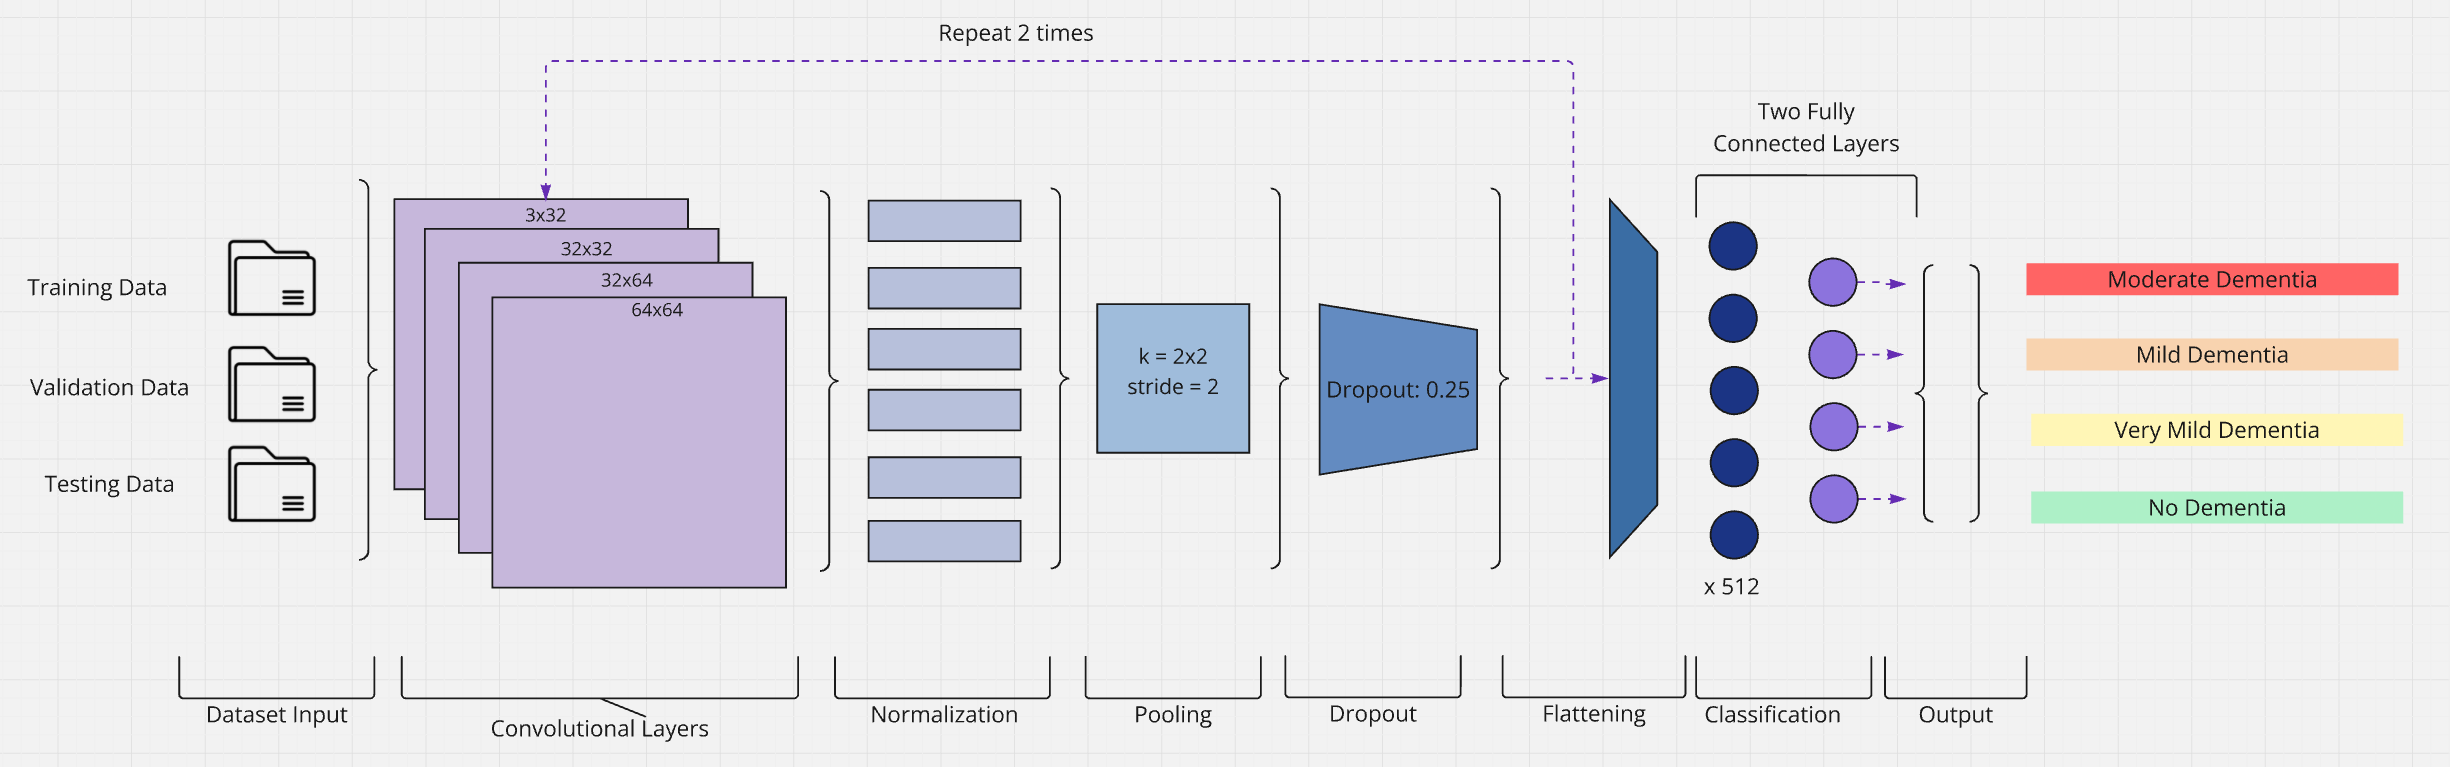

Model Architecture Overview
Input: MRI scan images of size 128x128 with 3 channels (RGB)

*   **Convolutional Layers:** Two blocks with 32 and 64 filters, using 2×2 kernel size with padding
*   **Pooling:** Max Pooling (2×2, stride 2) for dimensionality reduction
*   **Dropout:** Applied after convolutional and fully connected layers to prevent overfitting
*   **Fully Connected Layers:** One hidden layer with 512 neurons followed by the final classification layer with 4 outputs
*   **Activation Functions:** ReLU in hidden layers, log softmax for multi-class classification

This model is implemented using PyTorch and optimized for multi-class classification of dementia severity. Below is the complete implementation of the model:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

class AlzheimerNet(nn.Module):
    def __init__(self):
        super(AlzheimerNet, self).__init__()

        # First Conv Block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        # Second Conv Block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        # Fully Connected Layers
        self.flattened_size = self._get_flattened_size()
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 4)  # 4 output classes

    def _get_flattened_size(self):
        """ Compute size after convolutions before passing to Linear layers """
        dummy_input = torch.zeros(1, 3, 128, 128)  # Example input size
        with torch.no_grad():
            x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(dummy_input)))))
            x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        return x.view(1, -1).size(1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  # Log softmax for multi-class classification

# Initialize model and move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlzheimerNet().to(device)

# Print model summary
summary(model, input_size=(1, 3, 128, 128), device=device.type)


Layer (type:depth-idx)                   Output Shape              Param #
AlzheimerNet                             [1, 4]                    --
├─Conv2d: 1-1                            [1, 32, 129, 129]         416
├─Conv2d: 1-2                            [1, 32, 130, 130]         4,128
├─BatchNorm2d: 1-3                       [1, 32, 130, 130]         64
├─MaxPool2d: 1-4                         [1, 32, 65, 65]           --
├─Dropout: 1-5                           [1, 32, 65, 65]           --
├─Conv2d: 1-6                            [1, 64, 66, 66]           8,256
├─Conv2d: 1-7                            [1, 64, 67, 67]           16,448
├─BatchNorm2d: 1-8                       [1, 64, 67, 67]           128
├─MaxPool2d: 1-9                         [1, 64, 33, 33]           --
├─Dropout: 1-10                          [1, 64, 33, 33]           --
├─Linear: 1-11                           [1, 512]                  35,684,864
├─Dropout: 1-12                          [1, 512]                

In [ ]:

# Compute the number of trainable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {num_params}")

Total trainable parameters: 35716356


In [ ]:
import torch.optim as optim
import numpy as np
import time

def evaluate(net, data_loader, criterion):
    """ Evaluate the model on validation/test data. """
    net.eval()  # Set model to evaluation mode
    total_loss, total_err, total_samples = 0.0, 0.0, 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = net(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total_err += (predicted != labels).sum().item()
            total_loss += loss.item()
            total_samples += labels.size(0)

    error_rate = total_err / total_samples if total_samples > 0 else 0
    avg_loss = total_loss / len(data_loader) if len(data_loader) > 0 else 0
    return error_rate, avg_loss

In [ ]:
def train_net(net, train_loader, val_loader, batch_size=64, learning_rate=0.001, num_epochs=30):
    """ Train the AlzheimerNet model on the MRI dataset. """

    # Fixed random seed for reproducibility
    torch.manual_seed(1000)

    # Move model to GPU if available
    net.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Multi-class classification
    optimizer = optim.AdamW(net.parameters(), lr=learning_rate, weight_decay=1e-4)  # AdamW for weight decay handling
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate decay

    # Store training/validation metrics
    train_err, train_loss = np.zeros(num_epochs), np.zeros(num_epochs)
    val_err, val_loss = np.zeros(num_epochs), np.zeros(num_epochs)

    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()  # Set model to training mode
        total_train_loss, total_train_err, total_samples = 0.0, 0.0, 0

        for images, labels in train_loader:
            # Move data to GPU if available
            images = images.to(device)
            labels = labels.to(device).long()  # Ensure labels are LongTensor

            optimizer.zero_grad()  # Reset gradients
            outputs = net(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            # Compute training error
            _, predicted = torch.max(outputs, 1)
            total_train_err += (predicted != labels).sum().item()
            total_train_loss += loss.item()
            total_samples += labels.size(0)

        # Store average loss and error for this epoch
        train_err[epoch] = total_train_err / total_samples if total_samples > 0 else 0
        train_loss[epoch] = total_train_loss / len(train_loader) if len(train_loader) > 0 else 0

        # Compute validation error and loss
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)

        print(f"Epoch {epoch + 1}: Train Err: {train_err[epoch]:.4f}, Train Loss: {train_loss[epoch]:.4f} | "
              f"Val Err: {val_err[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}")

        # Step the learning rate scheduler
        scheduler.step()

    print("Finished Training")
    print(f"Total training time: {time.time() - start_time:.2f} seconds")

    return train_err, train_loss, val_err, val_loss  # Return metrics for plotting


In [ ]:
# Convert from one-hot to class indices BEFORE converting to tensors
y_train = np.argmax(y_train, axis=1)  # Convert from one-hot to class index
y_test = np.argmax(y_test, axis=1)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Labels should be long for CrossEntropyLoss

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Custom Dataset
class AlzheimerMRIDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]  # No need to call .item()

# Define batch size
batch_size = 64

# Create datasets
train_dataset = AlzheimerMRIDataset(X_train_tensor, y_train_tensor)
val_dataset = AlzheimerMRIDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model = AlzheimerNet().to(device)  # Instantiate the model and move it to GPU
AlzheimerNet_results = train_net(model, train_loader, val_loader, batch_size=64, learning_rate=0.001, num_epochs=30)

##Plotting the results of the primary model

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(results, model_name):
    """
    Plots the training curves for a given model.

    Args:
        results (tuple): A tuple (train_err, train_loss, val_err, val_loss).
        model_name (str): Name of the model for the plot title.
    """
    train_err, train_loss, val_err, val_loss = results  # Unpack tuple
    epochs = range(1, len(train_err) + 1)

    # Train vs Validation Error
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_err, label="Train Error")
    plt.plot(epochs, val_err, label="Validation Error")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.title(f"{model_name} - Train vs Validation Error")
    plt.legend()
    plt.grid()
    plt.show()

    # Train vs Validation Loss
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Train vs Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
plot_training_curves(AlzheimerNet_results, "AlzheimerNet CNN Model")

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert NumPy arrays to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Ensure correct type
y_test_tensor = torch.tensor(y_test, dtype=torch.long)     # Ensure labels are Long type

# Reshape X_test to (batch, channels, height, width)
X_test_tensor = X_test_tensor.permute(0, 3, 1, 2)  # Move channels to first dimension

# Create a TensorDataset
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Get predicted class (highest probability)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())  # True labels
            y_pred.extend(preds.cpu().numpy())   # Predicted labels

    # Convert lists to NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')  # Weighted for multi-class
    recall = recall_score(y_true, y_pred, average='weighted')  # Weighted for multi-class
    f1 = f1_score(y_true, y_pred, average='weighted')  # Weighted for multi-class

    return y_true, y_pred, accuracy, precision, recall, f1


def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

class_names = ["Non-Demented", "Mild Dementia", "Moderate Dementia", "Very Mild Dementia"]  # Update based on dataset


In [ ]:
# Evaluate model
y_true, y_pred, accuracy, precision, recall, f1 = evaluate_model(model, test_loader, device)

# Print metrics
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

# Plot Confusion Matrix
plot_confusion_matrix(y_true, y_pred, class_names)


# Transfer Learning


ResNet152 Transfer Learning for Alzheimer's Detection

This implementation fine-tunes ResNet152, a deep convolutional neural network, to classify brain MRI scans into four categories:

*   No Dementia
*   Very Mild Dementia
*   Mild Dementia
*   Moderate Dementia

The model utilizes transfer learning, leveraging pretrained weights from ImageNet and modifying the classifier head for multi-class classification. The architecture is visualized below:

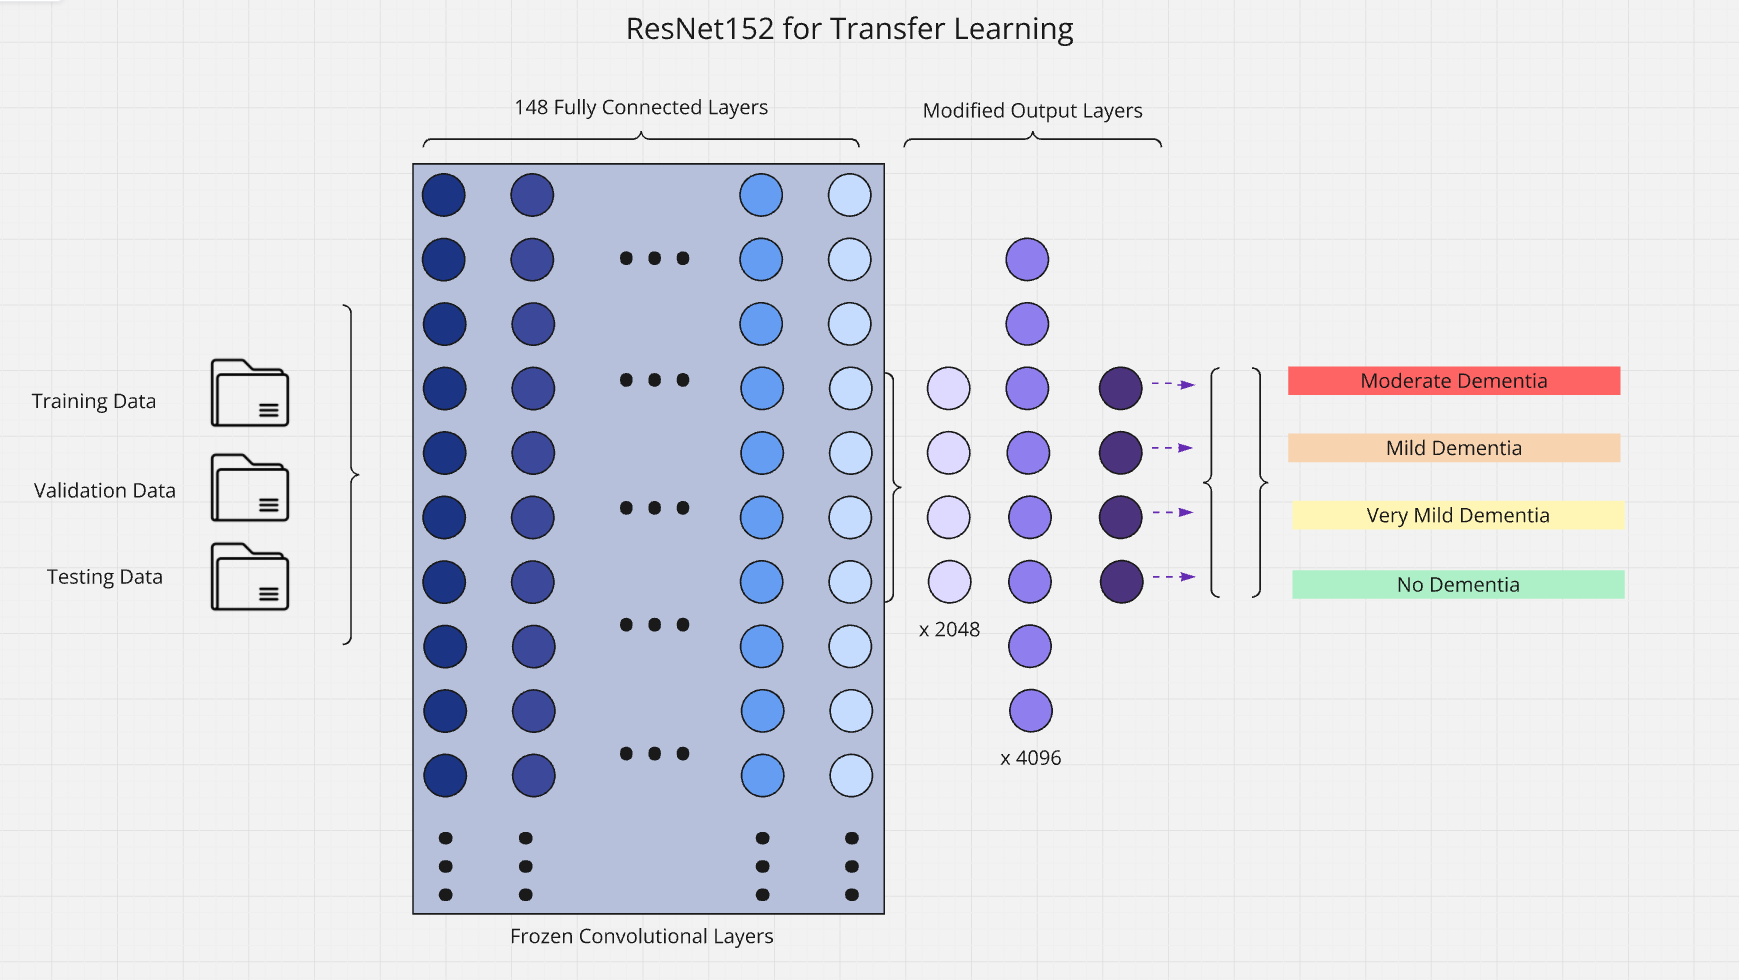

Model Architecture & Customization:
*   **Base Model:** ResNet152 pretrained on ImageNet
*   **Frozen Layers:** The initial convolutional layers remain frozen to retain learned low-level features.
*   Fine-Tuned Layers: Layers 2, 3, and 4 are unfrozen for domain-specific feature extraction.
*   Modified Fully Connected Head:
     *   **Input:** 2048 feature vectors from ResNet’s last convolutional layer
     *   **Hidden Layers:** 2048 → 4096 → 1024 neurons with ReLU activation and dropout (0.5) to prevent overfitting
     *   **Output Layer:** 4 neurons (one per class) with softmax activation

Training Configuration"

Batch Size: 32

*   **Learning Rate:** 0.00005
*   **Epochs:** 40
*   **Optimizer:** Adam (fine-tuning only unfrozen layers)
*   **Loss Function:** Cross-Entropy

The model is trained on MRI scans with separate training, validation, and testing datasets to ensure robust performance.

In [ ]:
import torchvision.models as models
import torch.nn as nn
from torchvision.models import ResNet152_Weights

class ResNet152Alzheimer(nn.Module):
    def __init__(self, pretrained=True, dropout_rate=0.5):
        """
        Initialize the ResNet152 Alzheimer model

        Args:
            pretrained (bool): Whether to use pretrained weights
            dropout_rate (float): Dropout rate for classifier (default: 0.5)
        """
        super(ResNet152Alzheimer, self).__init__()

        # Load pre-trained ResNet152
        self.model = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V1 if pretrained else None)

        # Freeze all layers first
        self._freeze_all_layers()

        # Unfreeze specific layers
        self._unfreeze_selected_layers()f

        # Modify the classifier head
        self._modify_classifier(num_classes=4, dropout_rate=dropout_rate)

    def _freeze_all_layers(self):
        """Freeze all model parameters"""
        for param in self.model.parameters():
            param.requires_grad = False

    def _unfreeze_selected_layers(self):
        """Unfreeze layer2, layer3, and layer4"""
        for param in self.model.layer2.parameters():
            param.requires_grad = True
        for param in self.model.layer3.parameters():
            param.requires_grad = True
        for param in self.model.layer4.parameters():
            param.requires_grad = True

    def _modify_classifier(self, num_classes, dropout_rate):
        """Replace the final fully connected layer"""
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 2048),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes),)

    def forward(self, x):
        """Forward pass"""
        return self.model(x)


# Initialize the model
resnet152_model = ResNet152Alzheimer(pretrained=True, dropout_rate=0.5).to(device)

# Training configuration (same as original)
train_config = {
    'batch_size': 32,
    'learning_rate': 0.00005,
    'num_epochs': 40
}

# Train the model
resnet152_results = train_net(
    resnet152_model,
    train_loader,
    val_loader,
    batch_size=train_config['batch_size'],
    learning_rate=train_config['learning_rate'],
    num_epochs=train_config['num_epochs']
)

# Evaluate the model
y_true, y_pred, accuracy, precision, recall, f1 = evaluate_model(resnet152_model, test_loader, device)

# Print metrics
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

# Plot results
plot_confusion_matrix(y_true, y_pred, class_names)
plot_training_curves(resnet152_results, "ResNet152 Transfer Learning Model")

Epoch 1: Train Err: 0.4257, Train Loss: 1.0543 | Val Err: 0.2667, Val Loss: 0.8857
Epoch 2: Train Err: 0.1088, Train Loss: 0.6110 | Val Err: 0.2000, Val Loss: 0.8275
Epoch 3: Train Err: 0.0426, Train Loss: 0.4627 | Val Err: 0.1708, Val Loss: 0.7119


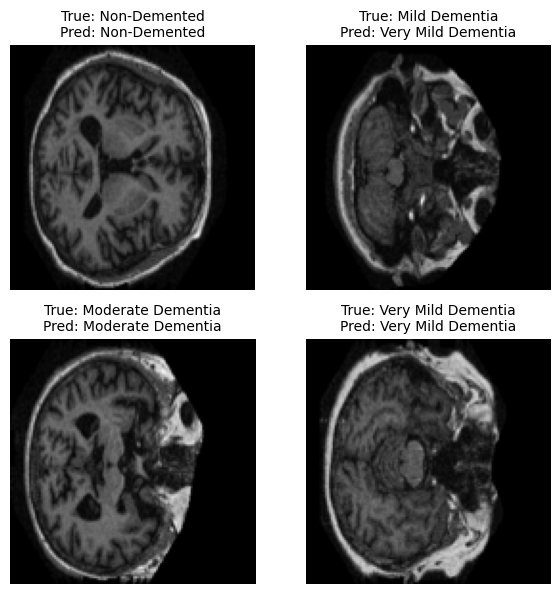

In [ ]:
def display_sample_outputs_per_category_grid(model, data_loader, device, class_names):
    """
    Displays one sample image per category in a 2x2 grid with their true and predicted labels.

    Args:
        model (nn.Module): Trained model.
        data_loader (DataLoader): DataLoader for the test dataset.
        device (torch.device): Device used for inference.
        class_names (list): List of class names corresponding to labels.
    """
    num_categories = len(class_names)
    samples = {}  # To store one sample per category

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            # Loop through the batch
            for i in range(len(labels)):
                true_label = int(labels[i])
                if true_label not in samples:
                    samples[true_label] = (inputs[i].cpu(), true_label, int(preds[i].cpu()))
                # If we've collected one sample per category, break out
                if len(samples) == num_categories:
                    break
            if len(samples) == num_categories:
                break

    # Create a 2x2 grid for plotting
    fig, axes = plt.subplots(2, 2, figsize=(7, 7))
    axes = axes.ravel()  # Flatten the axes array

    for cat in range(num_categories):
        if cat in samples:
            img, true_label, pred_label = samples[cat]
            # Convert image from (C, H, W) to (H, W, C)
            img_np = img.permute(1, 2, 0).numpy()
            # Convert to uint8 if needed
            if img_np.dtype != np.uint8 and img_np.max() > 1:
                img_np = img_np.astype(np.uint8)
            axes[cat].imshow(img_np)
            axes[cat].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", fontsize=10)
            axes[cat].axis("off")
        else:
            axes[cat].axis("off")
            axes[cat].set_title("No Sample", fontsize=20)

    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()

# Example usage:
display_sample_outputs_per_category_grid(resnet152_model, test_loader, device, class_names)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load ResNet152 pretrained model
class AlzheimerResNet(nn.Module):
    def __init__(self):
        super(AlzheimerResNet, self).__init__()

        # Load ResNet152 backbone (excluding last FC layer)
        self.resnet = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)
        num_ftrs = self.resnet.fc.in_features  # Get number of features in last FC layer

        # Replace the FC layer with custom classification head
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 1024),
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(1024, 4),  # 4-class classification
        )

    def forward(self, x):
        return self.resnet(x)

# initialize model
model = AlzheimerResNet().to(device)

# freeze initial layers (feature extractor)
for param in model.resnet.parameters():
    param.requires_grad = False

for param in model.resnet.layer2.parameters():
    param.requires_grad = True
for param in model.resnet.layer3.parameters():
    param.requires_grad = True
for param in model.resnet.layer4.parameters():
    param.requires_grad = True


# un-freeze final layers for training
for param in model.resnet.fc.parameters():
    param.requires_grad = True

class_weights = torch.tensor([1.0, 1.5, 2.5, 4.0]).to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)

#for name, param in model.named_parameters():
#    print(f"{name}: Requires Grad = {param.requires_grad}")

#optimizer = optim.Adam(model.resnet.fc.parameters(), lr=0.0001)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


Using device: cuda


In [ ]:
import time

# training function
def train_model(model, train_loader, val_loader, num_epochs=10):
    """ Train the model and evaluate performance """
    model.train()
    for epoch in range(num_epochs):
        total_loss, correct = 0, 0
        start_time = time.time()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #scheduler.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = correct / len(train_loader.dataset)
        val_acc = evaluate_model(model, val_loader)

        print(f"Epoch {epoch+1}: Train Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f} | Time: {time.time() - start_time:.2f}s")

        scheduler.step()

# evaluation function
def evaluate_model(model, val_loader):
    """ Evaluate model accuracy on validation set """
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct += (outputs.argmax(1) == labels).sum().item()

    return correct / len(val_loader.dataset)

# fine-tuning function (after initial training)
def fine_tune_model(model, train_loader, val_loader, num_epochs=5):
    """ Unfreeze deeper layers and fine-tune the model """
    for param in model.resnet.layer4.parameters():  # un-freeze last ResNet block
        param.requires_grad = True

    #optimizer = optim.Adam(model.parameters(), lr=1e-5)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    train_model(model, train_loader, val_loader, num_epochs)

In [ ]:
# convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)

# custom Dataset class
class AlzheimerMRIDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# create DataLoaders
batch_size = 64
train_loader = DataLoader(AlzheimerMRIDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(AlzheimerMRIDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

In [ ]:
del model
torch.cuda.empty_cache()  # Clear GPU memory

# Reinitialize the model
model = AlzheimerResNet().to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)


print("\nTraining ResNet152 (Feature Extractor)...")
train_model(model, train_loader, val_loader, num_epochs=30)


Training ResNet152 (Feature Extractor)...
Epoch 1: Train Loss: 30.0378, Train Acc: 0.2809, Val Acc: 0.2833 | Time: 10.98s
Epoch 2: Train Loss: 27.1729, Train Acc: 0.2926, Val Acc: 0.2500 | Time: 10.62s
Epoch 3: Train Loss: 22.7976, Train Acc: 0.3456, Val Acc: 0.3542 | Time: 10.75s
Epoch 4: Train Loss: 16.4543, Train Acc: 0.5735, Val Acc: 0.5708 | Time: 10.74s
Epoch 5: Train Loss: 8.2984, Train Acc: 0.8632, Val Acc: 0.6875 | Time: 10.87s
Epoch 6: Train Loss: 3.1847, Train Acc: 0.9581, Val Acc: 0.7250 | Time: 10.95s
Epoch 7: Train Loss: 1.3515, Train Acc: 0.9860, Val Acc: 0.7083 | Time: 11.23s
Epoch 8: Train Loss: 0.7665, Train Acc: 0.9949, Val Acc: 0.7458 | Time: 11.09s
Epoch 9: Train Loss: 0.2363, Train Acc: 0.9978, Val Acc: 0.7542 | Time: 10.96s
Epoch 10: Train Loss: 0.0923, Train Acc: 0.9993, Val Acc: 0.7542 | Time: 11.03s
Epoch 11: Train Loss: 0.0451, Train Acc: 1.0000, Val Acc: 0.7542 | Time: 10.69s
Epoch 12: Train Loss: 0.0295, Train Acc: 1.0000, Val Acc: 0.7500 | Time: 10.70s
Ep

In [ ]:
print("\nFine-Tuning ResNet152...")
fine_tune_model(model, train_loader, val_loader, num_epochs=10)


Fine-Tuning ResNet152...
Epoch 1: Train Loss: 21.3734, Train Acc: 0.6390, Val Acc: 0.5750 | Time: 11.09s
Epoch 2: Train Loss: 6.3228, Train Acc: 0.9125, Val Acc: 0.6417 | Time: 10.68s
Epoch 3: Train Loss: 5.4507, Train Acc: 0.9184, Val Acc: 0.7083 | Time: 10.68s
Epoch 4: Train Loss: 3.6221, Train Acc: 0.9441, Val Acc: 0.7833 | Time: 10.69s
Epoch 5: Train Loss: 1.0207, Train Acc: 0.9882, Val Acc: 0.7375 | Time: 10.69s
Epoch 6: Train Loss: 0.2812, Train Acc: 0.9978, Val Acc: 0.7625 | Time: 10.68s
Epoch 7: Train Loss: 0.0580, Train Acc: 1.0000, Val Acc: 0.7667 | Time: 10.69s
Epoch 8: Train Loss: 0.0214, Train Acc: 1.0000, Val Acc: 0.7792 | Time: 10.69s
Epoch 9: Train Loss: 0.0108, Train Acc: 1.0000, Val Acc: 0.7750 | Time: 10.70s
Epoch 10: Train Loss: 0.0076, Train Acc: 1.0000, Val Acc: 0.7833 | Time: 10.69s



 Model Evaluation Metrics:
Accuracy:  0.8042
Precision: 0.8134
Recall:    0.8042
F1-score:  0.8065


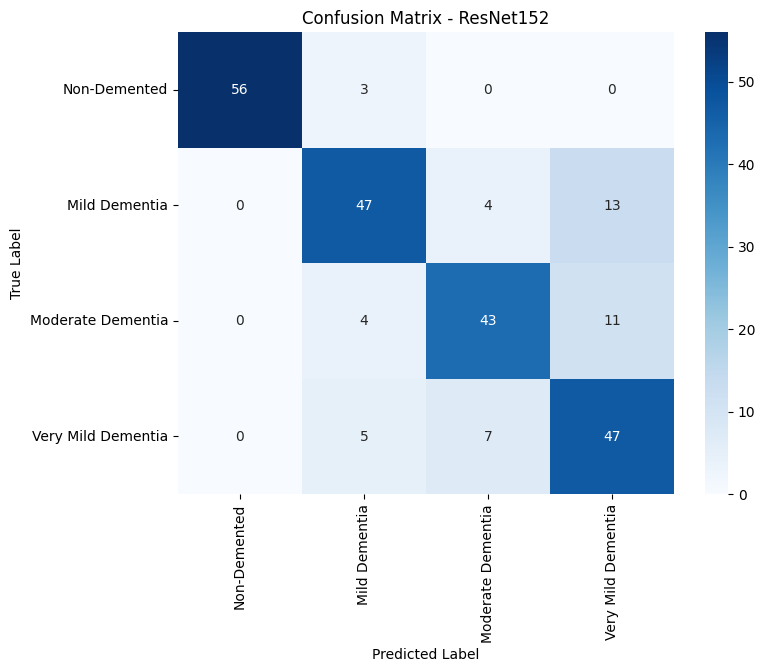

In [ ]:
def evaluate_and_plot_metrics(model, test_loader, class_names):
    """ Evaluate the model and plot confusion matrix """
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Get predicted class (highest probability)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())  # True labels
            y_pred.extend(preds.cpu().numpy())   # Predicted labels

    # Convert lists to NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\n Model Evaluation Metrics:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - ResNet152")
    plt.show()

# Define class names
class_names = ["Non-Demented", "Mild Dementia", "Moderate Dementia", "Very Mild Dementia"]

# Create test DataLoader
test_loader = DataLoader(AlzheimerMRIDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

# Run evaluation
evaluate_and_plot_metrics(model, test_loader, class_names)

# Hyperparameter Tuning

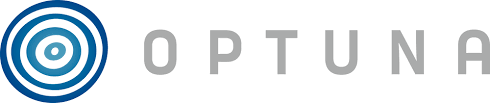

To optimize model performance, we will use Optuna for automated hyperparameter tuning. The goal is to maximize the recall score, as it is the most critical metric for our task.

We will search over the following hyperparameters:

1. **Learning Rate:** Continuous range from 1e-7 to 1e-2 (log-uniform distribution)

2. **Epochs:** Integer values from 10 to 80

3. **Batch Size:** Categorical choices of [16, 32, 64, 128]

Optuna will efficiently explore the search space using its Tree-structured Parzen Estimator (TPE) sampler to find the optimal configuration that yields the highest recall on the validation set.

For the optuna reference, we can check this link:
https://www.kaggle.com/code/pavansanagapati/automated-hyperparameter-tuning

In [ ]:
!pip install -q optuna

Evaluate Function

In [ ]:
import torch.optim as optim
import numpy as np
import time

import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate(net, data_loader, criterion):
    """ Evaluate the model on validation/test data. """
    net.eval()  # Set model to evaluation mode
    total_loss, total_err, total_samples = 0.0, 0.0, 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = net(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total_err += (predicted != labels).sum().item()
            total_loss += loss.item()
            total_samples += labels.size(0)

    error_rate = total_err / total_samples if total_samples > 0 else 0
    avg_loss = total_loss / len(data_loader) if len(data_loader) > 0 else 0
    return error_rate, avg_loss

def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Get predicted class (highest probability)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())  # True labels
            y_pred.extend(preds.cpu().numpy())   # Predicted labels

    # Convert lists to NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')  # Weighted for multi-class
    recall = recall_score(y_true, y_pred, average='weighted')  # Weighted for multi-class
    f1 = f1_score(y_true, y_pred, average='weighted')  # Weighted for multi-class

    return y_true, y_pred, accuracy, precision, recall, f1

Train net function

In [ ]:
def train_net(net, train_loader, val_loader, batch_size=64, learning_rate=0.001, num_epochs=30):
    """ Train the AlzheimerNet model on the MRI dataset. """

    # Fixed random seed for reproducibility
    torch.manual_seed(1000)

    # Move model to GPU if available
    net.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Multi-class classification
    optimizer = optim.AdamW(net.parameters(), lr=learning_rate, weight_decay=1e-4)  # AdamW for weight decay handling
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate decay

    # Store training/validation metrics
    train_err, train_loss = np.zeros(num_epochs), np.zeros(num_epochs)
    val_err, val_loss = np.zeros(num_epochs), np.zeros(num_epochs)

    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()  # Set model to training mode
        total_train_loss, total_train_err, total_samples = 0.0, 0.0, 0

        for images, labels in train_loader:
            # Move data to GPU if available
            images = images.to(device)
            labels = labels.to(device).long()  # Ensure labels are LongTensor

            optimizer.zero_grad()  # Reset gradients
            outputs = net(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            # Compute training error
            _, predicted = torch.max(outputs, 1)
            total_train_err += (predicted != labels).sum().item()
            total_train_loss += loss.item()
            total_samples += labels.size(0)

        # Store average loss and error for this epoch
        train_err[epoch] = total_train_err / total_samples if total_samples > 0 else 0
        train_loss[epoch] = total_train_loss / len(train_loader) if len(train_loader) > 0 else 0

        # Compute validation error and loss
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)

        print(f"Epoch {epoch + 1}: Train Err: {train_err[epoch]:.4f}, Train Loss: {train_loss[epoch]:.4f} | "
              f"Val Err: {val_err[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}")

        # Step the learning rate scheduler
        scheduler.step()

    print("Finished Training")
    print(f"Total training time: {time.time() - start_time:.2f} seconds")

    return train_err, train_loss, val_err, val_loss  # Return metrics for plotting

Model Function

In [ ]:
import torchvision.models as models
import torch.nn as nn
from torchvision.models import ResNet152_Weights

class ResNet152Alzheimer(nn.Module):
    def __init__(self, pretrained=True, dropout_rate=0.5):
        """
        Initialize the ResNet152 Alzheimer model

        Args:
            pretrained (bool): Whether to use pretrained weights
            dropout_rate (float): Dropout rate for classifier (default: 0.5)
        """
        super(ResNet152Alzheimer, self).__init__()

        # Load pre-trained ResNet152
        self.model = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V1 if pretrained else None)

        # Freeze all layers first
        self._freeze_all_layers()

        # Unfreeze specific layers
        self._unfreeze_selected_layers()

        # Modify the classifier head
        self._modify_classifier(num_classes=4, dropout_rate=dropout_rate)

    def _freeze_all_layers(self):
        """Freeze all model parameters"""
        for param in self.model.parameters():
            param.requires_grad = False

    def _unfreeze_selected_layers(self):
        """Unfreeze layer2, layer3, and layer4"""
        for param in self.model.layer2.parameters():
            param.requires_grad = True
        for param in self.model.layer3.parameters():
            param.requires_grad = True
        for param in self.model.layer4.parameters():
            param.requires_grad = True

    def _modify_classifier(self, num_classes, dropout_rate):
        """Replace the final fully connected layer"""
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 2048),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes),)

    def forward(self, x):
        """Forward pass"""
        return self.model(x)

Prepare the dataset

In [ ]:
# Convert from one-hot to class indices BEFORE converting to tensors
import torch
from torch.utils.data import TensorDataset, DataLoader

try:
    y_train = np.argmax(y_train, axis=1)  # Convert from one-hot to class index
    y_test = np.argmax(y_test, axis=1)
except ValueError:
    # If already a class index, no need to convert
    pass

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Labels should be long for CrossEntropyLoss

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create a TensorDataset
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Optuna

In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
# from model import AlzheimerResNet  # Make sure your model is imported

def objective(trial):
    # 🔧 Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-7, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    epochs = trial.suggest_int('epochs', 10, 15)

    # Initialize the model
    model = ResNet152Alzheimer(pretrained=True, dropout_rate=0.5).to(device)

    # Custom Dataset
    class AlzheimerMRIDataset(Dataset):
      def __init__(self, images, labels):
          self.images = images
          self.labels = labels

      def __len__(self):
          return len(self.images)

      def __getitem__(self, idx):
          return self.images[idx], self.labels[idx]  # No need to call .item()
    # batch_size = 64

    # Create datasets
    train_dataset = AlzheimerMRIDataset(X_train_tensor, y_train_tensor)
    val_dataset = AlzheimerMRIDataset(X_test_tensor, y_test_tensor)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # 🏋️ Train the model using your custom train_net function
    val_metric = train_net(
        net=model,
        train_loader=train_loader,
        val_loader=val_loader,
        batch_size=batch_size,
        learning_rate=lr,
        num_epochs=epochs
    )

    y_true, y_pred, accuracy, precision, recall, f1 = evaluate_model(model, test_loader, device)

    conf_matrix = confusion_matrix(y_true, y_pred)
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Random Forest")
    plt.show()

    # 🎯 Optuna minimizes by default, so invert if higher = better (like accuracy)
    return -recall  # Use `val_metric` if it's loss; `-val_metric` if it's accuracy


In [ ]:
study = optuna.create_study(direction="minimize")  # or "maximize" if accuracy
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2025-04-04 00:38:50,611] A new study created in memory with name: no-name-f963944b-5370-4088-ac20-7a408ab2a00f
<ipython-input-29-700b0d7be35c>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-7, 1e-2)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:08<00:00, 28.7MB/s]


Epoch 1: Train Err: 0.7402, Train Loss: 1.3862 | Val Err: 0.7006, Val Loss: 1.3848
Epoch 2: Train Err: 0.7245, Train Loss: 1.3845 | Val Err: 0.6614, Val Loss: 1.3830
Epoch 3: Train Err: 0.7053, Train Loss: 1.3827 | Val Err: 0.6253, Val Loss: 1.3810
Epoch 4: Train Err: 0.6875, Train Loss: 1.3807 | Val Err: 0.6033, Val Loss: 1.3788
Epoch 5: Train Err: 0.6691, Train Loss: 1.3790 | Val Err: 0.5706, Val Loss: 1.3762
Epoch 6: Train Err: 0.6523, Train Loss: 1.3765 | Val Err: 0.5658, Val Loss: 1.3733


In [ ]:
import pandas as pd
import optuna

# After study.optimize() has finished

# Extract trial data
records = []
for trial in study.trials:
    if trial.value is not None:
        record = trial.params.copy()
        record['recall'] = -trial.value  # Because you minimized -recall
        records.append(record)

# Create DataFrame
df = pd.DataFrame(records)

# Optional: Sort by best recall
df = df.sort_values(by='recall', ascending=False).reset_index(drop=True)

# Display the top trials
from ace_tools import display_dataframe_to_user
display_dataframe_to_user(name="Optuna Recall by Parameters", dataframe=df)


In [ ]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()


# Demonstration

## Save the model

In [ ]:
import torch.optim as optim
import numpy as np
import time

import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate(net, data_loader, criterion):
    """ Evaluate the model on validation/test data. """
    net.eval()  # Set model to evaluation mode
    total_loss, total_err, total_samples = 0.0, 0.0, 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = net(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total_err += (predicted != labels).sum().item()
            total_loss += loss.item()
            total_samples += labels.size(0)

    error_rate = total_err / total_samples if total_samples > 0 else 0
    avg_loss = total_loss / len(data_loader) if len(data_loader) > 0 else 0
    return error_rate, avg_loss

def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Get predicted class (highest probability)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())  # True labels
            y_pred.extend(preds.cpu().numpy())   # Predicted labels

    # Convert lists to NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')  # Weighted for multi-class
    recall = recall_score(y_true, y_pred, average='weighted')  # Weighted for multi-class
    f1 = f1_score(y_true, y_pred, average='weighted')  # Weighted for multi-class

    return y_true, y_pred, accuracy, precision, recall, f1

def train_net(net, train_loader, val_loader, batch_size=64, learning_rate=0.001, num_epochs=30):
    """ Train the AlzheimerNet model on the MRI dataset. """

    # Fixed random seed for reproducibility
    torch.manual_seed(1000)

    # Move model to GPU if available
    net.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Multi-class classification
    optimizer = optim.AdamW(net.parameters(), lr=learning_rate, weight_decay=1e-4)  # AdamW for weight decay handling
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate decay

    # Store training/validation metrics
    train_err, train_loss = np.zeros(num_epochs), np.zeros(num_epochs)
    val_err, val_loss = np.zeros(num_epochs), np.zeros(num_epochs)

    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()  # Set model to training mode
        total_train_loss, total_train_err, total_samples = 0.0, 0.0, 0

        for images, labels in train_loader:
            # Move data to GPU if available
            images = images.to(device)
            labels = labels.to(device).long()  # Ensure labels are LongTensor

            optimizer.zero_grad()  # Reset gradients
            outputs = net(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            # Compute training error
            _, predicted = torch.max(outputs, 1)
            total_train_err += (predicted != labels).sum().item()
            total_train_loss += loss.item()
            total_samples += labels.size(0)

        # Store average loss and error for this epoch
        train_err[epoch] = total_train_err / total_samples if total_samples > 0 else 0
        train_loss[epoch] = total_train_loss / len(train_loader) if len(train_loader) > 0 else 0

        # Compute validation error and loss
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)

        print(f"Epoch {epoch + 1}: Train Err: {train_err[epoch]:.4f}, Train Loss: {train_loss[epoch]:.4f} | "
              f"Val Err: {val_err[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}")

        # Step the learning rate scheduler
        scheduler.step()

    print("Finished Training")
    print(f"Total training time: {time.time() - start_time:.2f} seconds")

    return train_err, train_loss, val_err, val_loss  # Return metrics for plotting

import torchvision.models as models
import torch.nn as nn
from torchvision.models import ResNet152_Weights

class ResNet152Alzheimer(nn.Module):
    def __init__(self, pretrained=True, dropout_rate=0.5):
        """
        Initialize the ResNet152 Alzheimer model

        Args:
            pretrained (bool): Whether to use pretrained weights
            dropout_rate (float): Dropout rate for classifier (default: 0.5)
        """
        super(ResNet152Alzheimer, self).__init__()

        # Load pre-trained ResNet152
        self.model = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V1 if pretrained else None)

        # Freeze all layers first
        self._freeze_all_layers()

        # Unfreeze specific layers
        self._unfreeze_selected_layers()

        # Modify the classifier head
        self._modify_classifier(num_classes=4, dropout_rate=dropout_rate)

    def _freeze_all_layers(self):
        """Freeze all model parameters"""
        for param in self.model.parameters():
            param.requires_grad = False

    def _unfreeze_selected_layers(self):
        """Unfreeze layer2, layer3, and layer4"""
        for param in self.model.layer2.parameters():
            param.requires_grad = True
        for param in self.model.layer3.parameters():
            param.requires_grad = True
        for param in self.model.layer4.parameters():
            param.requires_grad = True

    def _modify_classifier(self, num_classes, dropout_rate):
        """Replace the final fully connected layer"""
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 2048),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes),)

    def forward(self, x):
        """Forward pass"""
        return self.model(x)


try:
    y_train = np.argmax(y_train, axis=1)  # Convert from one-hot to class index
    y_test = np.argmax(y_test, axis=1)
except ValueError:
    # If already a class index, no need to convert
    pass

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Labels should be long for CrossEntropyLoss

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create a TensorDataset
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Best parameter:

{'lr': 0.0002661932441019303, 'batch_size': 128, 'epochs': 14}

{'lr': 7.741926085296505e-05, 'batch_size': 32, 'epochs': 14}

In [ ]:
# Initialize the model
model = ResNet152Alzheimer(pretrained=True, dropout_rate=0.5).to(device)

# Custom Dataset
class AlzheimerMRIDataset(Dataset):
  def __init__(self, images, labels):
      self.images = images
      self.labels = labels

  def __len__(self):
      return len(self.images)

  def __getitem__(self, idx):
      return self.images[idx], self.labels[idx]  # No need to call .item()

batch_size = 32

# Create datasets
train_dataset = AlzheimerMRIDataset(X_train_tensor, y_train_tensor)
val_dataset = AlzheimerMRIDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 🏋️ Train the model using your custom train_net function
val_metric = train_net(
    net=model,
    train_loader=train_loader,
    val_loader=val_loader,
    batch_size=batch_size,
    learning_rate=7.741926085296505e-05,
    num_epochs=10
)

Epoch 1: Train Err: 0.2075, Train Loss: 0.7134 | Val Err: 0.0883, Val Loss: 0.5098
Epoch 2: Train Err: 0.0447, Train Loss: 0.4466 | Val Err: 0.0264, Val Loss: 0.4035
Epoch 3: Train Err: 0.0200, Train Loss: 0.3967 | Val Err: 0.0389, Val Loss: 0.4269
Epoch 4: Train Err: 0.0158, Train Loss: 0.3880 | Val Err: 0.0389, Val Loss: 0.4318
Epoch 5: Train Err: 0.0101, Train Loss: 0.3759 | Val Err: 0.0767, Val Loss: 0.5163
Epoch 6: Train Err: 0.0111, Train Loss: 0.3766 | Val Err: 0.0333, Val Loss: 0.4209
Epoch 7: Train Err: 0.0085, Train Loss: 0.3725 | Val Err: 0.0394, Val Loss: 0.4379
Epoch 8: Train Err: 0.0078, Train Loss: 0.3687 | Val Err: 0.0319, Val Loss: 0.4240
Epoch 9: Train Err: 0.0072, Train Loss: 0.3686 | Val Err: 0.0222, Val Loss: 0.4075
Epoch 10: Train Err: 0.0090, Train Loss: 0.3730 | Val Err: 0.0350, Val Loss: 0.4399
Finished Training
Total training time: 1677.62 seconds


Precision: 0.9671
Recall: 0.9650
F1 Score: 0.9648


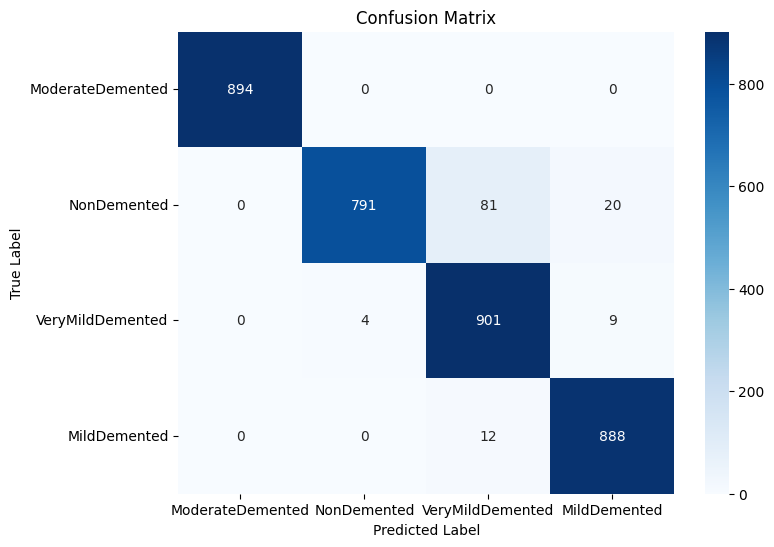

In [ ]:
y_true, y_pred, accuracy, precision, recall, f1 = evaluate_model(model, test_loader, device)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

conf_matrix = confusion_matrix(y_true, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import torch

# Assume 'model' is your trained model
torch.save(model.state_dict(), 'best_model.pth')

## Display the data for the demonstration

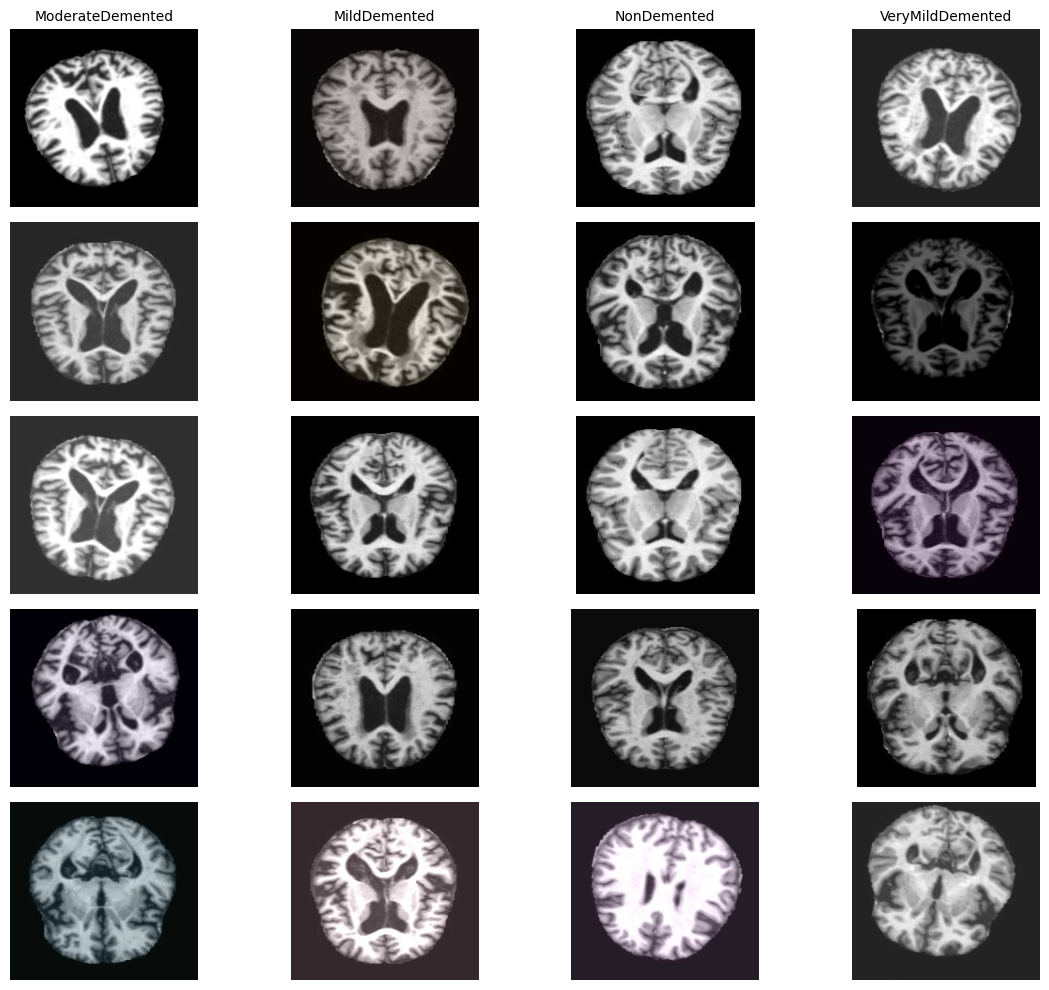

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Define category names
category_names = class_names

# Number of categories and images per category
num_categories = len(category_names)
images_per_category = 5

# Set up the figure for 5 rows and 4 columns (5 images per category, 4 categories)
fig, axes = plt.subplots(images_per_category, num_categories, figsize=(12, 10))

# Loop through each category and each image per category
for col in range(num_categories):  # Columns = categories
    for row in range(images_per_category):  # Rows = 0 to 4
        ax = axes[row, col]  # Get subplot

        try:
            img_path = array[col][-images_per_category + row]  # Last 5 images
            img = Image.open(img_path)  # Load image

            ax.imshow(img)
            ax.axis("off")

            if row == 0:
                ax.set_title(category_names[col], fontsize=10)
        except IndexError:
            ax.axis("off")  # In case fewer than 5 images in a category

# Adjust spacing
plt.tight_layout()
plt.show()


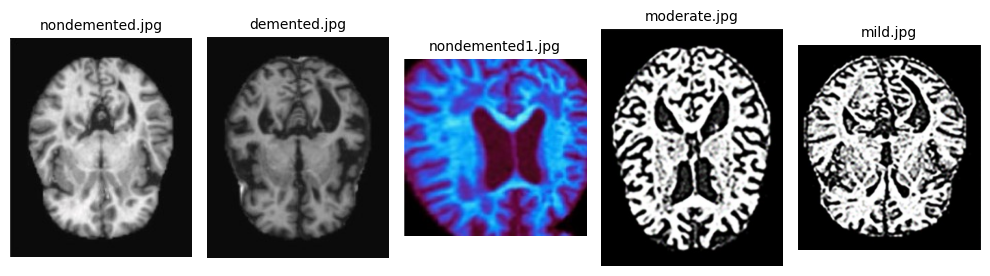

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Define image filenames (each treated as a separate "category")
image_files = ['nondemented.jpg', 'demented.jpg', 'nondemented1.jpg', 'moderate.jpg', 'mild.jpg']

# Number of images
num_images = len(image_files)

# Set up the figure — 1 row, N columns
fig, axes = plt.subplots(1, num_images, figsize=(2 * num_images, 5))

# If there's only 1 image, wrap axes in a list
if num_images == 1:
    axes = [axes]

# Loop through and display each image
for idx, (ax, image_name) in enumerate(zip(axes, image_files)):
    try:
        img = Image.open(image_name)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(image_name, fontsize=10)
    except Exception as e:
        ax.axis("off")
        ax.set_title("Error loading image")
        print(f"Error loading {image_name}: {e}")

# Adjust layout
plt.tight_layout()
plt.show()


## Test on new data

In [ ]:
import torchvision.models as models
import torch.nn as nn
from torchvision.models import ResNet152_Weights

class ResNet152Alzheimer(nn.Module):
    def __init__(self, pretrained=True, dropout_rate=0.5):
        """
        Initialize the ResNet152 Alzheimer model

        Args:
            pretrained (bool): Whether to use pretrained weights
            dropout_rate (float): Dropout rate for classifier (default: 0.5)
        """
        super(ResNet152Alzheimer, self).__init__()

        # Load pre-trained ResNet152
        self.model = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V1 if pretrained else None)

        # Freeze all layers first
        self._freeze_all_layers()

        # Unfreeze specific layers
        self._unfreeze_selected_layers()

        # Modify the classifier head
        self._modify_classifier(num_classes=4, dropout_rate=dropout_rate)

    def _freeze_all_layers(self):
        """Freeze all model parameters"""
        for param in self.model.parameters():
            param.requires_grad = False

    def _unfreeze_selected_layers(self):
        """Unfreeze layer2, layer3, and layer4"""
        for param in self.model.layer2.parameters():
            param.requires_grad = True
        for param in self.model.layer3.parameters():
            param.requires_grad = True
        for param in self.model.layer4.parameters():
            param.requires_grad = True

    def _modify_classifier(self, num_classes, dropout_rate):
        """Replace the final fully connected layer"""
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 2048),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes),)

    def forward(self, x):
        """Forward pass"""
        return self.model(x)

In [ ]:
# Load the model architecture first
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet152Alzheimer(pretrained=True, dropout_rate=0.5)
model.load_state_dict(torch.load('best_model_040425_1521.pth'))
model.eval()

In [ ]:
# class_names = ['Non Demented', 'Very mild Dementia', 'Moderate Dementia', 'Mild Dementia']

try:
    y_test = np.argmax(y_test, axis=1)
except ValueError:
    # If already a class index, no need to convert
    pass

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create a TensorDataset
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

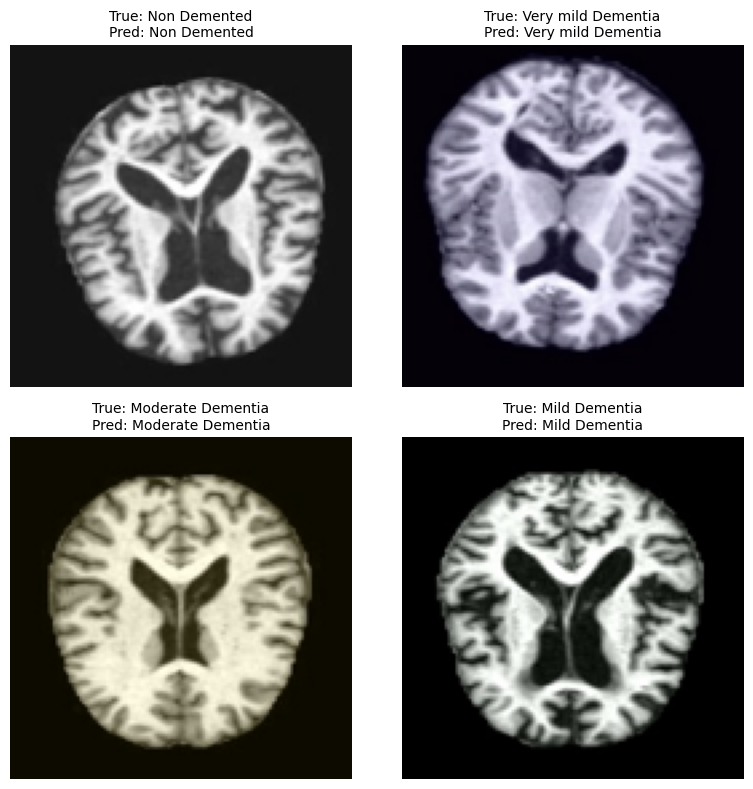

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

class_names = ['Non Demented', 'Very mild Dementia', 'Moderate Dementia', 'Mild Dementia']

def display_sample_outputs_per_category_grid(model, data_loader, device, class_names):
    num_categories = len(class_names)
    samples = {}  # Store one random sample per class

    model.eval()
    with torch.no_grad():
        all_inputs = []
        all_labels = []
        all_preds = []

        # Collect all predictions and images
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_inputs.append(inputs.cpu())
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

        # Concatenate everything
        all_inputs = torch.cat(all_inputs)
        all_labels = torch.cat(all_labels)
        all_preds = torch.cat(all_preds)

        # For each class, pick a random sample
        for cat in range(num_categories):
            indices = (all_labels == cat).nonzero(as_tuple=True)[0]
            if len(indices) > 0:
                random_idx = random.choice(indices)
                samples[cat] = (
                    all_inputs[random_idx],
                    int(all_labels[random_idx]),
                    int(all_preds[random_idx])
                )

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    axes = axes.ravel()

    for cat in range(num_categories):
        ax = axes[cat]
        if cat in samples:
            img_tensor, true_label, pred_label = samples[cat]
            img_np = img_tensor.permute(1, 2, 0).numpy()

            # if img_np.max() <= 1:
            #     img_np = (img_np * 255).astype(np.uint8)
            img_np = np.clip(img_np, 0, 255)  # Clip any float outliers
            if img_np.max() <= 1.0:
                img_np = (img_np * 255).astype(np.uint8)
            else:
                img_np = img_np.astype(np.uint8)


            ax.imshow(img_np)
            ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", fontsize=10)
            ax.axis("off")
        else:
            ax.axis("off")
            ax.set_title("No Sample", fontsize=20)

    plt.tight_layout()
    plt.show()

# Example usage:
display_sample_outputs_per_category_grid(model, test_loader, device, class_names)

## Test on never seen data

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert NumPy arrays to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Ensure correct type
y_test_tensor = torch.tensor(y_test, dtype=torch.long)     # Ensure labels are Long type

# Reshape X_test to (batch, channels, height, width)
X_test_tensor = X_test_tensor.permute(0, 3, 1, 2)  # Move channels to first dimension

# Create a TensorDataset
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


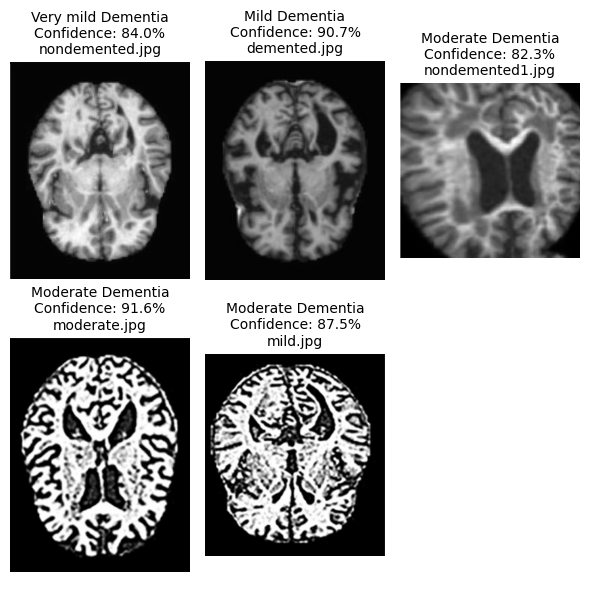

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Label mapping function
names = lambda i: ['Non Demented', 'Very mild Dementia', 'Moderate Dementia', 'Mild Dementia'][i]

# Model & device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Image files
image_files = ['nondemented.jpg', 'demented.jpg', 'nondemented1.jpg', 'moderate.jpg', 'mild.jpg']
IMAGE_SIZE = (128, 128)

# Layout: 2 rows, compute number of columns needed
n_images = len(image_files)
n_rows = 2
n_cols = (n_images + 1) // 2  # Ensures even when odd number of images

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 3 * n_rows))
axes = axes.flatten()  # Flatten to make iteration easier

# Loop through each image and subplot
for idx, file_path in enumerate(image_files):
    ax = axes[idx]
    try:
        # Load and preprocess image
        img = Image.open(file_path).convert('L')
        img_resized = img.resize(IMAGE_SIZE)
        img_array_gray = np.array(img_resized).astype(np.float32)
        img_array = np.stack([img_array_gray] * 3, axis=-1)
        img_tensor = torch.tensor(img_array).permute(2, 0, 1).unsqueeze(0).to(device)

        # Inference
        with torch.no_grad():
            output = model(img_tensor)
            probs = torch.softmax(output, dim=1)

            top2_confidences, top2_indices = torch.topk(probs, 2, dim=1)
            top1_conf = top2_confidences[0, 0].item()
            top1_class = top2_indices[0, 0].item()
            top2_class = top2_indices[0, 1].item()

            if top1_class == 0 and top1_conf < 0.70:
                predicted_class = top2_class
                confidence = top2_confidences[0, 1].item()
            else:
                predicted_class = top1_class
                confidence = top1_conf

        # Plot
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f"{names(predicted_class)}\nConfidence: {confidence*100:.1f}%\n{file_path}", fontsize=10)

    except Exception as e:
        ax.axis('off')
        ax.set_title("Error loading", fontsize=10)
        print(f"Error processing {file_path}: {e}")

# Hide any unused subplots
for ax in axes[n_images:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

**Dementia Stages (from better to worse):**

Non-Demented
*   Normal memory and thinking.
*   No noticeable cognitive issues.

Very Mild Dementia

*   Occasional forgetfulness (e.g., misplacing items).
*   No impact on daily life or independence.

Mild Dementia
*   Trouble with complex tasks (like managing money or planning).
*   May repeat questions or get lost in familiar places.
*   Still mostly independent, but needs some help.

Moderate Dementia
*   Significant memory loss and confusion.
*   Needs regular help with daily activities (dressing, cooking).
*   May not recognize familiar people or places.